In [5]:
import pandas as pd

# Baca file Excel
file_path = "dataset/Harga Konsumen Bapanas - Jatim Aja (N).xlsx"
sheet_name = "Forecast"

# Baca semua data tanpa header karena format tidak rapi
df_raw = pd.read_excel(file_path, sheet_name=sheet_name, header=None)

# Format: (nama_komoditas, baris_mulai_data, baris_akhir_data, kolom_mulai, kolom_akhir)
komoditas_list = [
    ("Beras Medium", 2, 14, 0, 5),     # Kolom A–E
    ("Beras Premium", 2, 14, 5, 10),   # Kolom F–J
    ("Gula", 2, 14, 10, 15),
    ("Minyak Goreng", 2, 14, 15, 20),
    ("Kedelai", 2, 14, 20, 25),
    ("Daging Ayam", 2, 14, 25, 30),
    ("Telur", 2, 14, 30, 35),
    ("Daging Sapi", 2, 14, 35, 40),
    ("Cabai Rawit", 2, 14, 40, 45),
    # ("Daging Ayam", 2, 14, 25, 30),
]
		

# Format hasil jadi dataframe panjang
all_data = []

for komoditas, row_start, row_end, col_start, col_end in komoditas_list:
    sub_df = df_raw.iloc[row_start:row_end, col_start:col_end]
    sub_df.columns = ["Bulan", "2022", "2023", "2024", "2025"]
    sub_df["Komoditas"] = komoditas
    all_data.append(sub_df)

# Gabungkan semua komoditas jadi satu DataFrame
df_concat = pd.concat(all_data, ignore_index=True)

# Ubah menjadi format long (tidy data)
df_long = pd.melt(
    df_concat,
    id_vars=["Komoditas", "Bulan"],
    value_vars=["2022", "2023", "2024", "2025"],
    var_name="Tahun",
    value_name="Harga"
)

# Ubah tipe data Harga menjadi numerik (jika ada string/NaN)
df_long["Harga"] = pd.to_numeric(df_long["Harga"], errors="coerce").round()
df_long = df_long.dropna(subset=["Harga"])
df_long["Harga"] = df_long["Harga"].astype(int)

# Tampilkan ringkasan hasil
# print(df_long.info())
df_long.to_csv("harga_konsumen_jatim.csv", index=False)


In [6]:
import pandas as pd

# Filter komoditas
df_beras = df_long[df_long["Komoditas"] == "Beras Medium"].copy()

# Buat kolom 'ds' dalam format yyyy-mm
month_map = {
    "Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04",
    "May": "05", "Jun": "06", "Jul": "07", "Aug": "08",
    "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"
}
df_beras["ds"] = df_beras["Tahun"].astype(str) + "-" + df_beras["Bulan"].map(month_map)

# Drop kolom tidak perlu dan pastikan 'y' bertipe integer murni
df_beras = df_beras[["ds", "Harga"]].rename(columns={"Harga": "y"})
df_beras["y"] = pd.to_numeric(df_beras["y"], errors="coerce").round()
df_beras = df_beras.dropna(subset=["y"])
df_beras["y"] = df_beras["y"].astype(int)

# Ubah ds menjadi datetime
df_beras["ds"] = pd.to_datetime(df_beras["ds"])

# Sort data
df_beras = df_beras.sort_values("ds").reset_index(drop=True)

df_beras.to_csv("harga_beras_medium.csv", index=False)

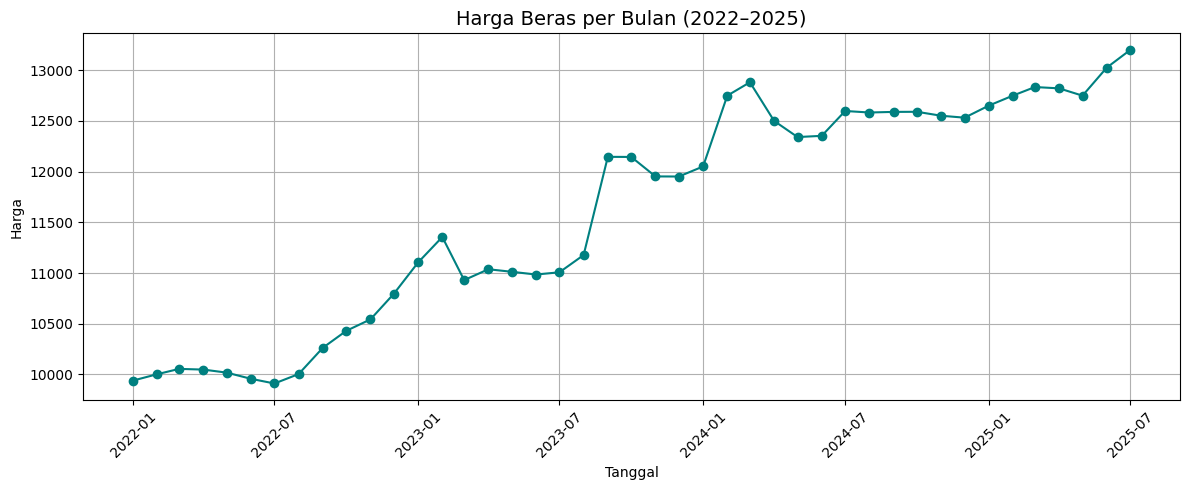

In [7]:
df_beras = pd.DataFrame(df_beras)
df_beras['ds'] = pd.to_datetime(df_beras['ds'])

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_beras['ds'], df_beras['y'], marker='o', linestyle='-', color='teal')
plt.title('Harga Beras per Bulan (2022–2025)', fontsize=14)
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

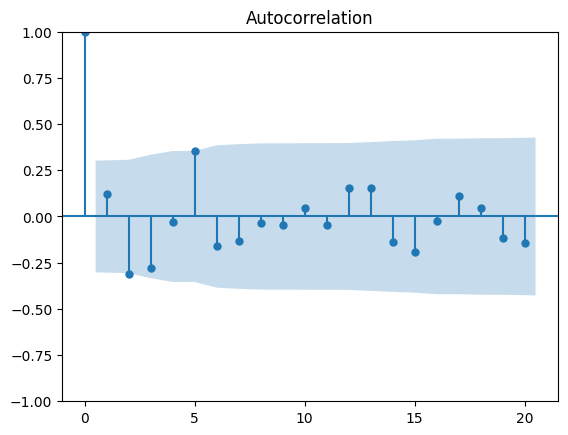

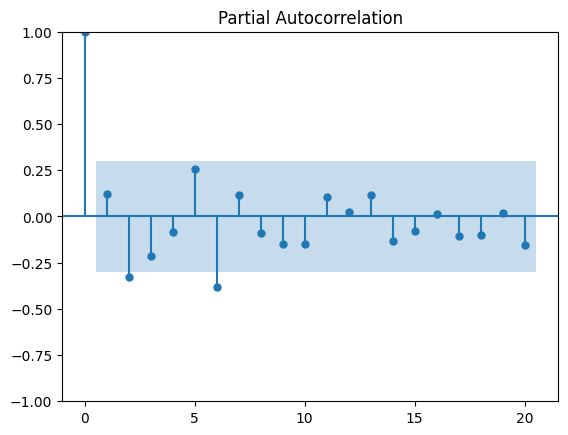

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(df_beras['y'].diff().dropna(), lags=20)
plot_pacf(df_beras['y'].diff().dropna(), lags=20)
plt.show()

In [9]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

df_beras = pd.read_csv("harga_beras_medium.csv")
# Pastikan df_beras sudah berbentuk DataFrame dengan kolom 'ds' sebagai datetime dan 'y' sebagai nilai
df_beras.rename(columns={'ds': 'Tanggal', 'y': 'Harga'}, inplace=True)
df_beras['Tanggal'] = pd.to_datetime(df_beras['Tanggal'])  # konversi jadi datetime
df_beras.set_index('Tanggal', inplace=True)                # set sebagai index


# Uji ADF (Augmented Dickey-Fuller) untuk mengecek stasioneritas
result = adfuller(df_beras['Harga'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] <= 0.05:
    print("✅ Data stasioner (tolak H0)")
else:
    print("❌ Data tidak stasioner (gagal tolak H0)")

ADF Statistic: -1.506689359438573
p-value: 0.530199651167134
❌ Data tidak stasioner (gagal tolak H0)


In [10]:
df_diff = df_beras['Harga'].diff().dropna()

result_diff = adfuller(df_diff)
print("ADF setelah differencing:", result_diff[0])
print("p-value:", result_diff[1])

ADF setelah differencing: -3.482869700434313
p-value: 0.008438090800341993


In [11]:
import pmdarima as pm

model_auto = pm.auto_arima(df_beras['Harga'], 
                           seasonal=False,
                           stepwise=True,
                           suppress_warnings=True,
                           trace=True,
                           error_action='ignore',
                           information_criterion='aic')

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=577.780, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=579.302, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=580.792, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=580.291, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=581.897, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=578.106, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=578.966, Time=0.66 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=580.154, Time=0.34 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=580.357, Time=0.34 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 4.81

In [13]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_beras['Harga'], order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

d:\MAGANG\Bulog\pycaret-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\MAGANG\Bulog\pycaret-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\MAGANG\Bulog\pycaret-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Harga   No. Observations:                   43
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -285.179
Date:                Tue, 29 Jul 2025   AIC                            580.357
Time:                        08:10:27   BIC                            589.046
Sample:                    01-01-2022   HQIC                           583.542
                         - 07-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0749      0.194      0.386      0.699      -0.305       0.455
ar.L2         -0.8664      0.177     -4.898      0.000      -1.213      -0.520
ma.L1          0.1648      0.198      0.832      0.4

d:\MAGANG\Bulog\pycaret-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\MAGANG\Bulog\pycaret-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\MAGANG\Bulog\pycaret-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


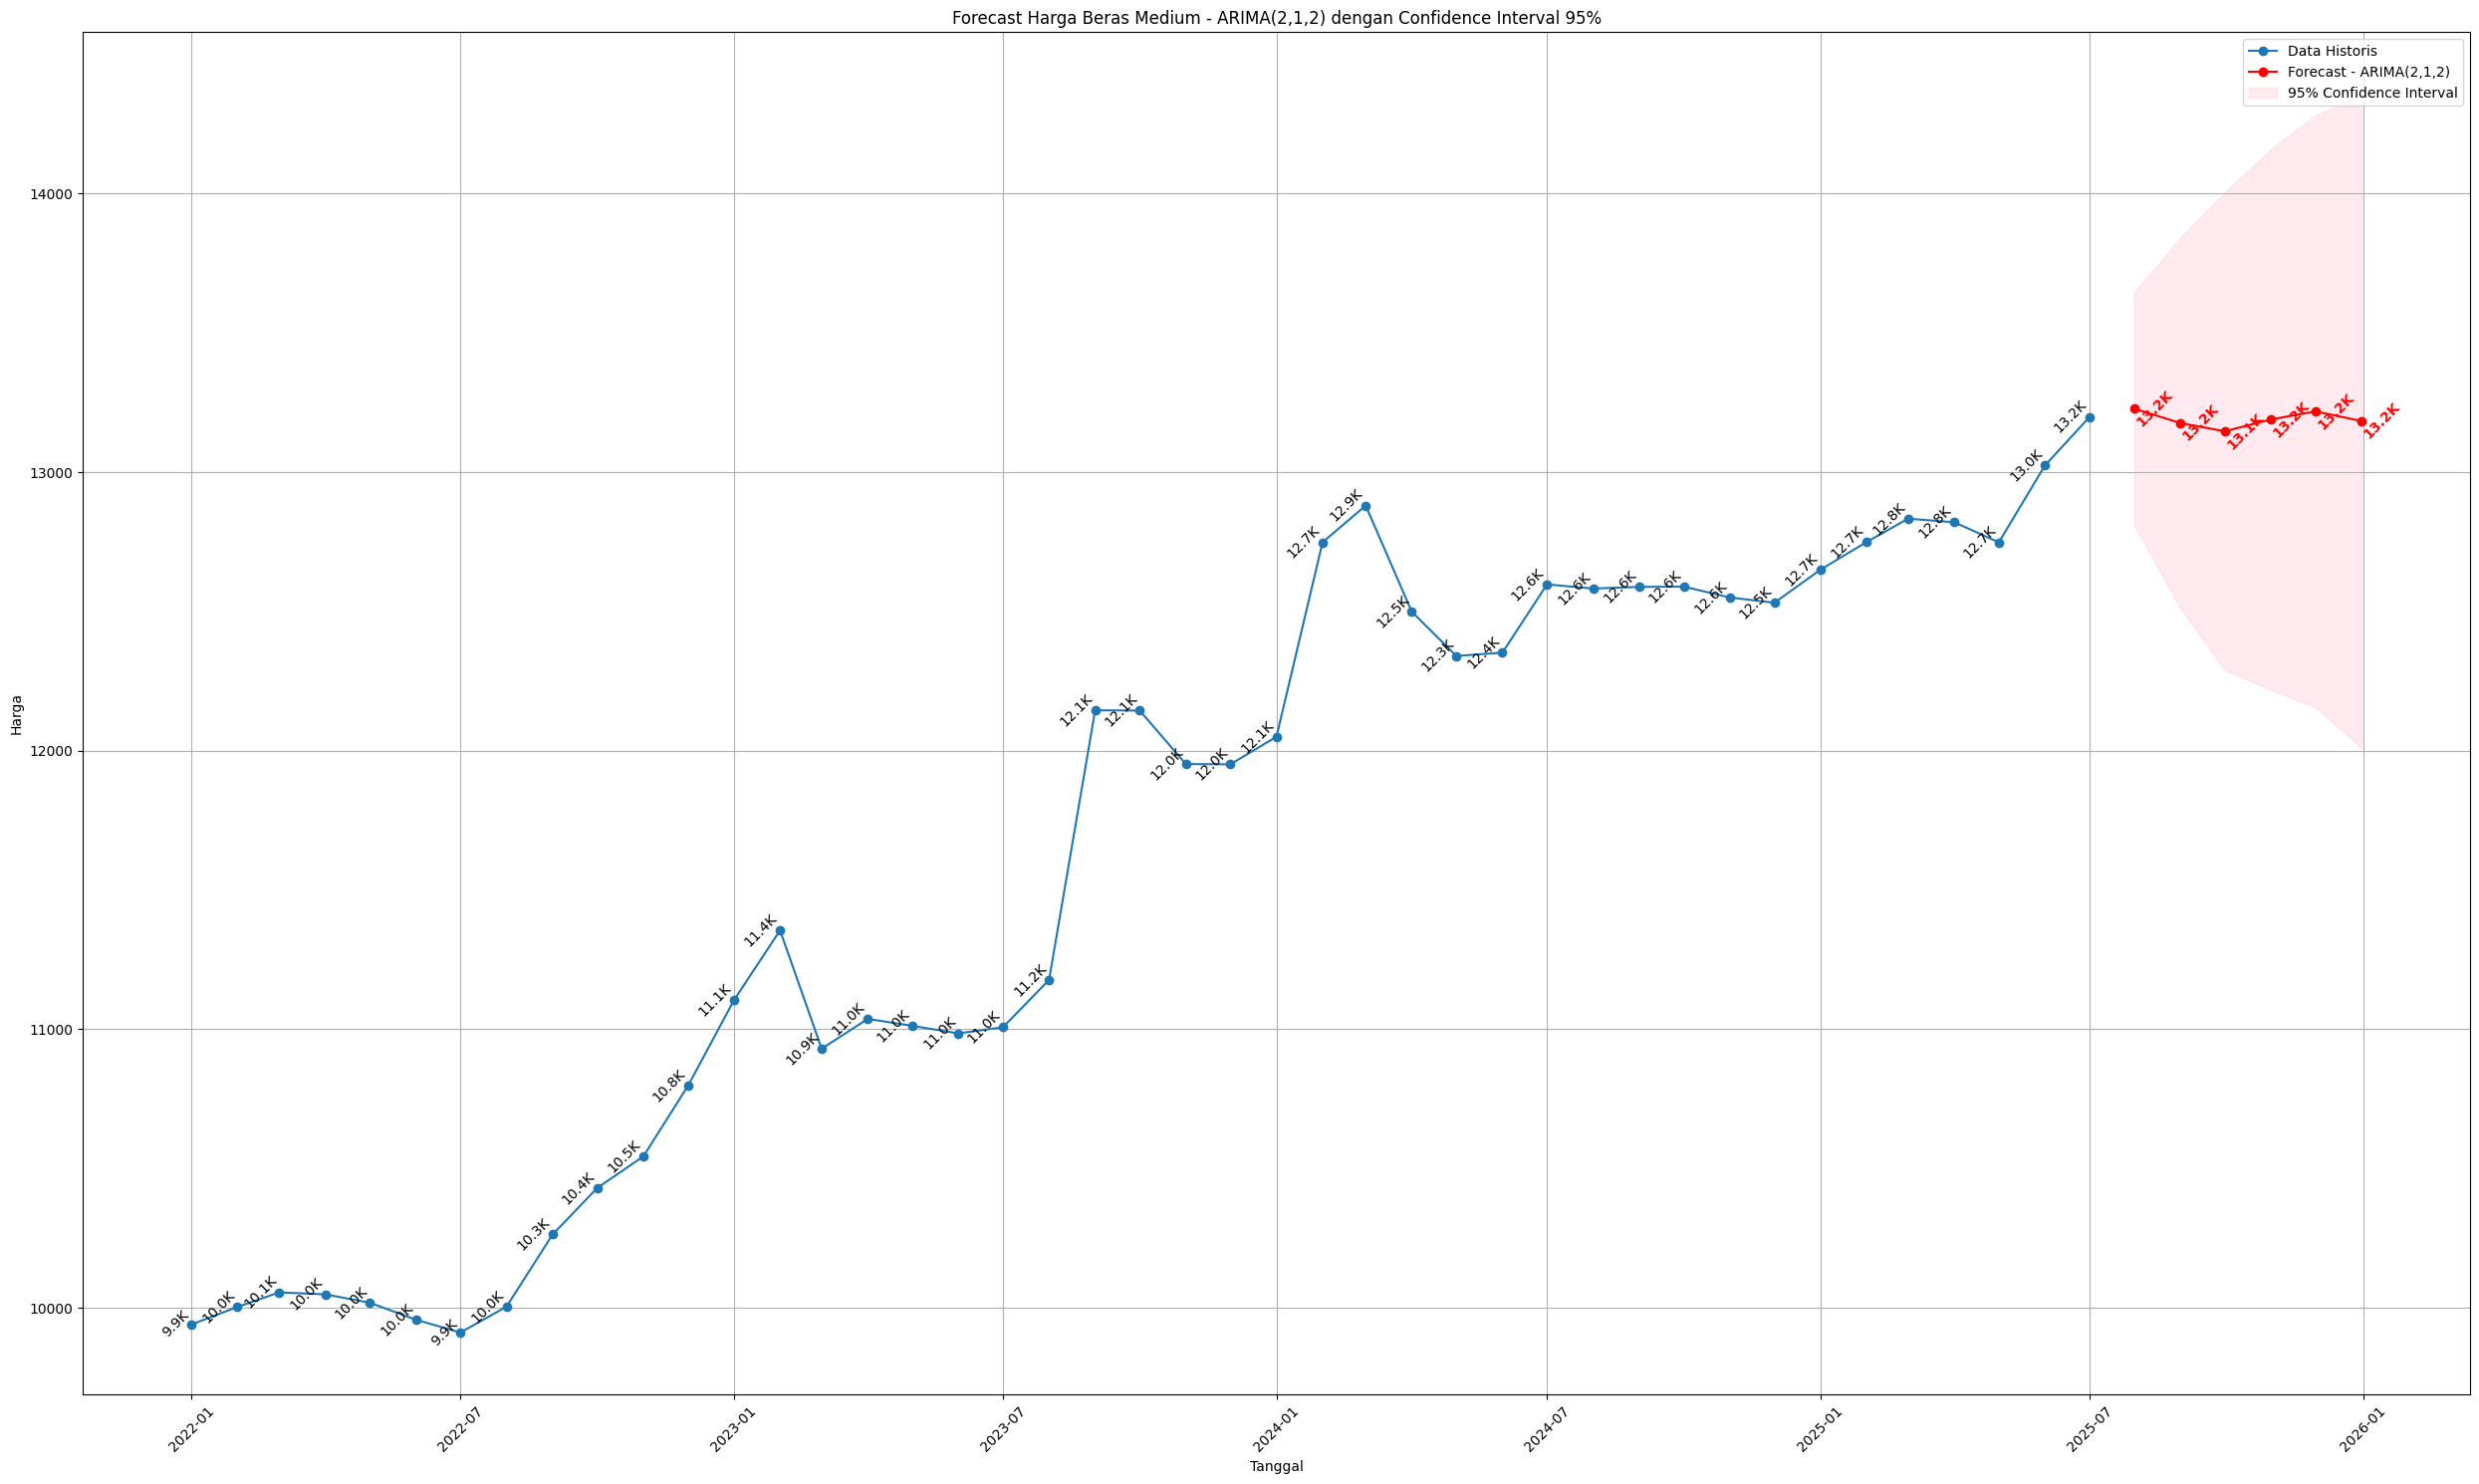

In [67]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Pastikan index terurut
df_beras = df_beras.sort_index()

# Fit model ARIMA(2,1,2)
model = ARIMA(df_beras['Harga'], order=(2, 1, 2))
model_fit = model.fit()

# Forecast dan confidence interval
forecast_object = model_fit.get_forecast(steps=6)
forecast = forecast_object.predicted_mean
conf_int = forecast_object.conf_int(alpha=0.05)  # 95% CI

# Buat index tanggal ke depan
last_date = df_beras.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthEnd(), periods=6, freq='M')

# Visualisasi
plt.figure(figsize=(25, 15))
plt.plot(df_beras.index, df_beras['Harga'], label='Data Historis', marker='o')
plt.plot(future_dates, forecast, label='Forecast - ARIMA(2,1,2)', color='red', marker='o')

# Tambahkan error band (confidence interval)
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

# Menampilkan nilai pada titik data historis
for i, value in enumerate(df_beras['Harga']):
    plt.text(df_beras.index[i], value + 0.5, f"{value/1000:.1f}K", ha="right", va='center', fontsize=10, rotation=45)

# Menampilkan nilai forecast
for i, value in enumerate(forecast):
    plt.text(future_dates[i], value + 0.5, f"{value/1000:.1f}K", ha='left', va='center', color='red', fontsize=10, rotation=45, weight='bold')

# Finalisasi tampilan
plt.title("Forecast Harga Beras Medium - ARIMA(2,1,2) dengan Confidence Interval 95%")
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Holt Winters

d:\MAGANG\Bulog\pycaret-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


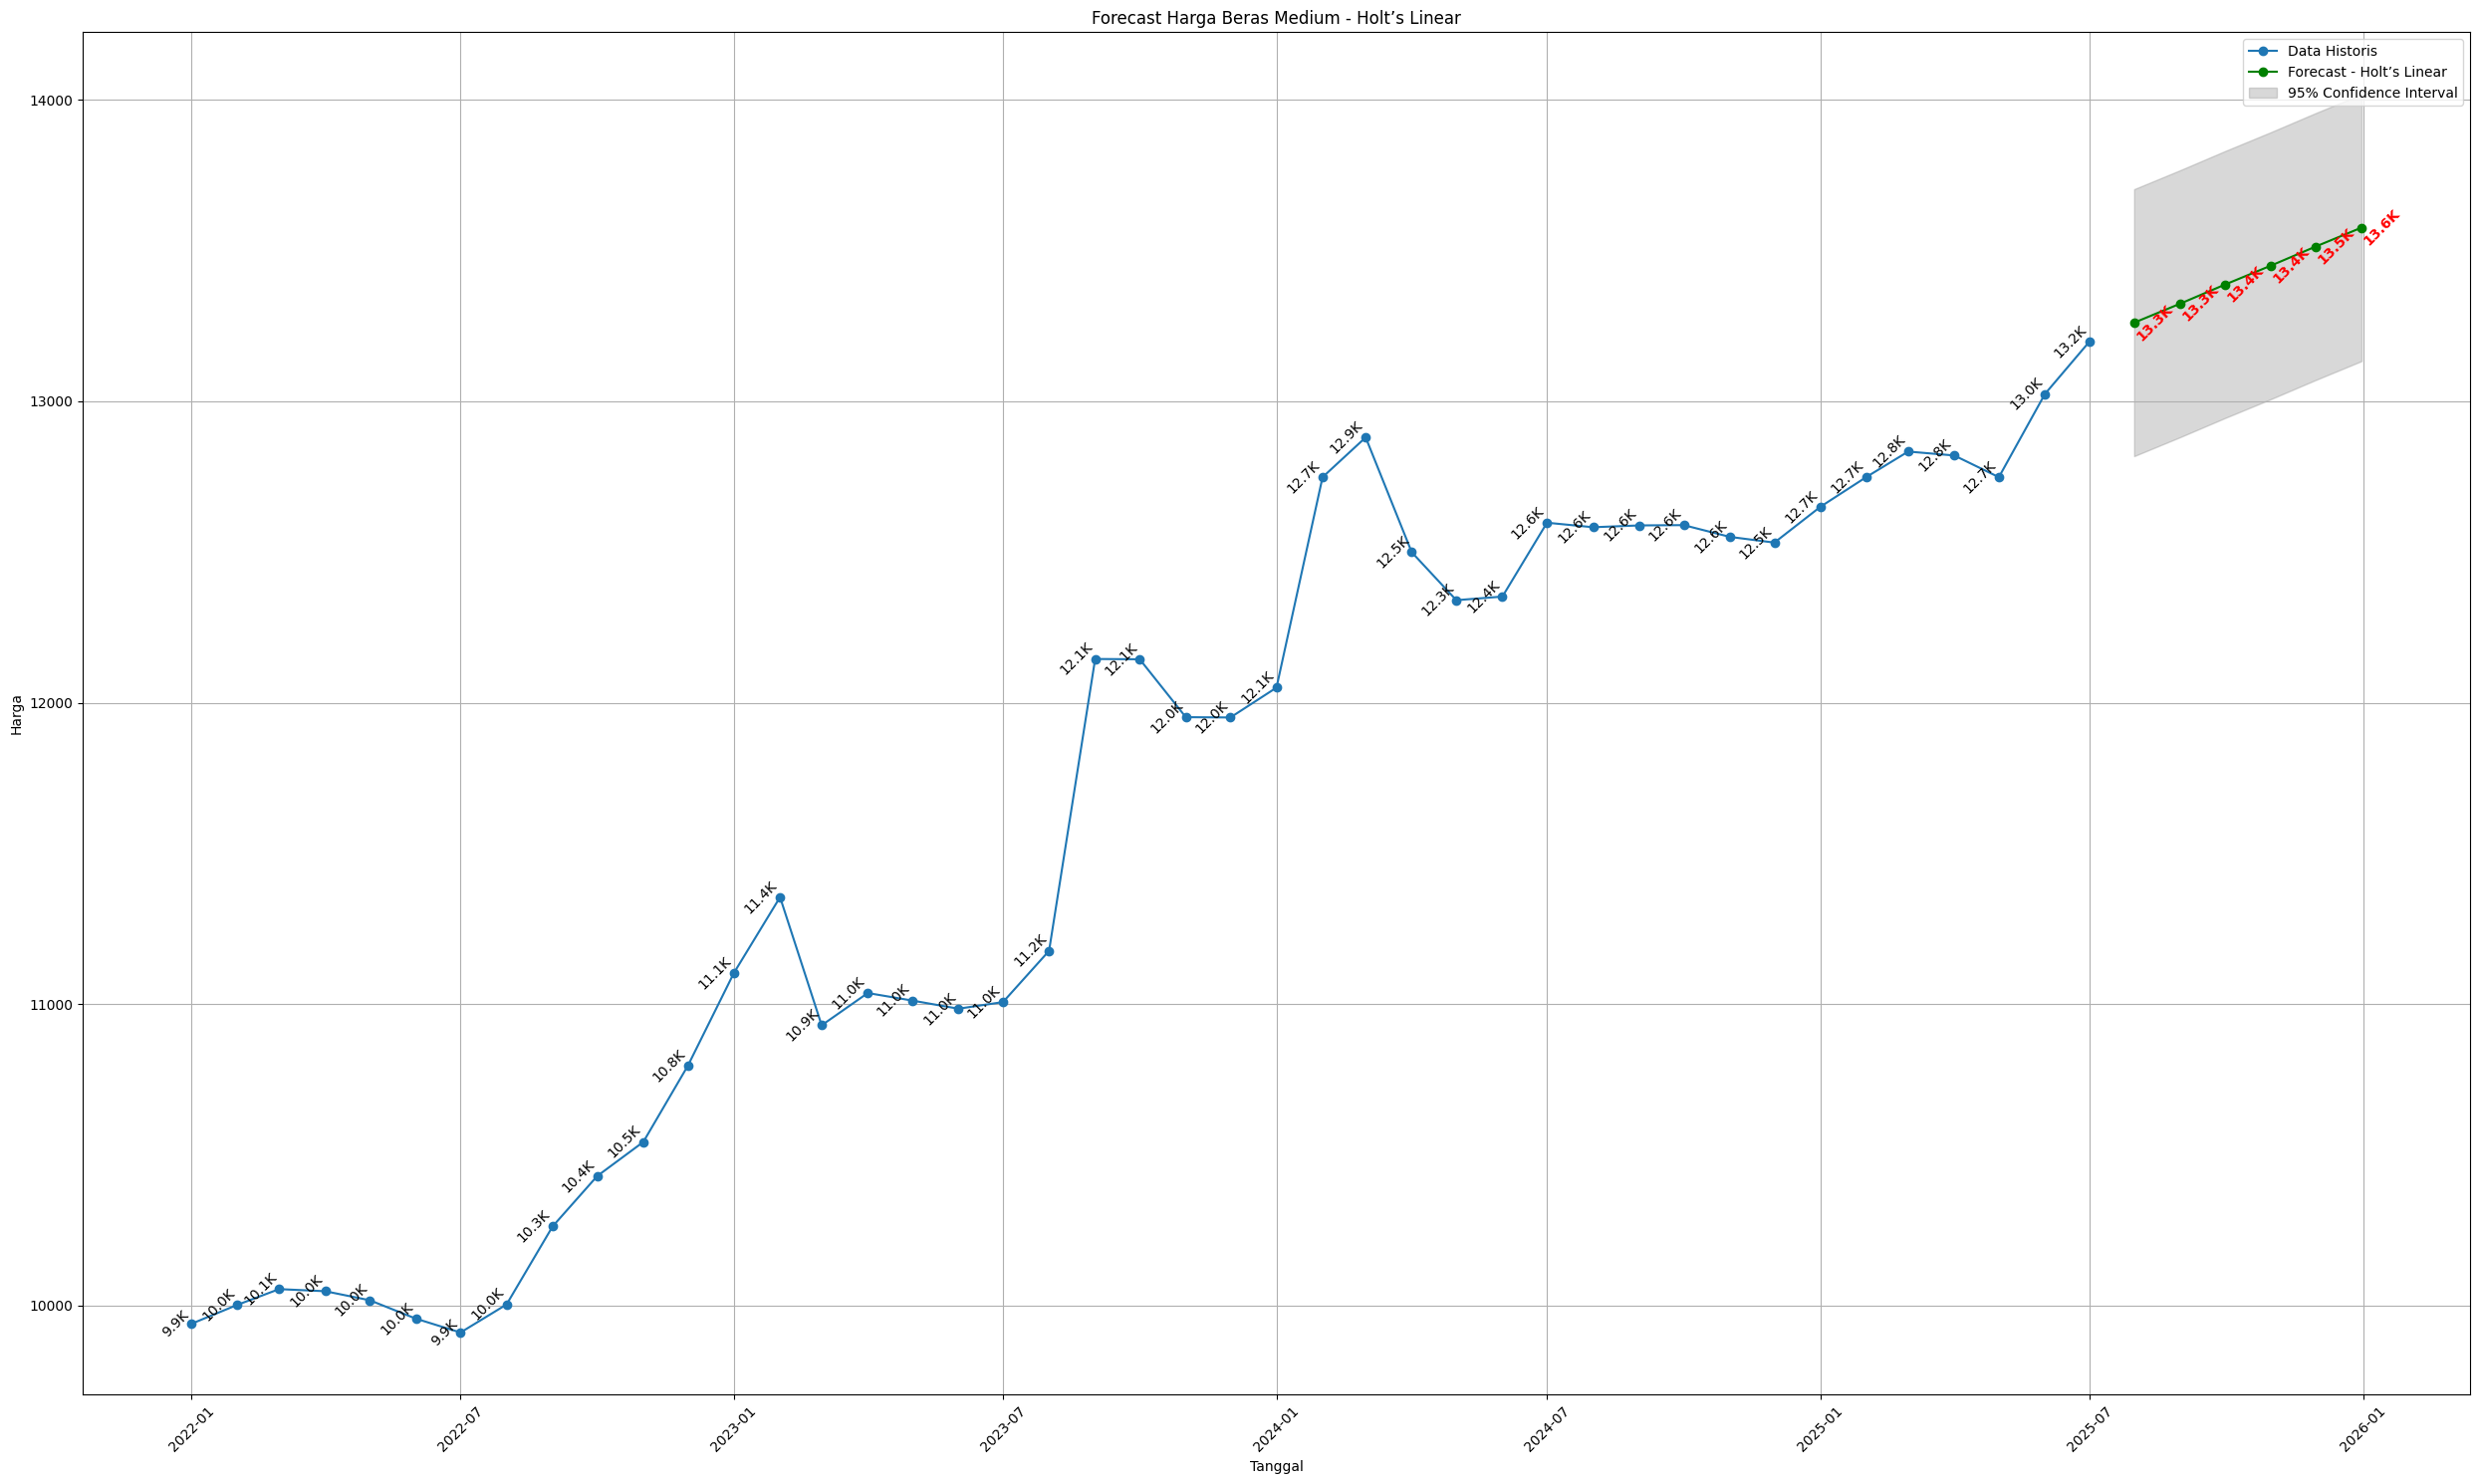

In [65]:
from statsmodels.tsa.holtwinters import Holt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Model Holt’s Linear
model = Holt(df_beras['Harga']).fit()
forecast_holt = model.forecast(steps=6)

# Tanggal prediksi
future_dates = pd.date_range(start=df_beras.index[-1] + pd.offsets.MonthEnd(), periods=6, freq='M')

# Hitung residual dan standar deviasi dari model
residuals = model.resid
std = np.std(residuals)

# Confidence interval (95%)
lower_bound = forecast_holt - 1.96 * std
upper_bound = forecast_holt + 1.96 * std

# Plot
plt.figure(figsize=(25, 15))
plt.plot(df_beras.index, df_beras['Harga'], label='Data Historis', marker='o')
plt.plot(future_dates, forecast_holt, label='Forecast - Holt’s Linear', color='green', marker='o')

# Menampilkan angka dari data historis
for i, value in enumerate(df_beras['Harga']):
    plt.text(df_beras.index[i], value + 0.5, f"{value/1000:.1f}K", ha="right", va='center', fontsize=10, rotation=45)

# Menampilkan angka dari hasil forecast
for i, value in enumerate(forecast_holt):
    plt.text(future_dates[i], value + 0.5, f"{value/1000:.1f}K", ha='left', va='center', color='red', fontsize=10, rotation=45, weight='bold')

plt.fill_between(future_dates, lower_bound, upper_bound, color='gray', alpha=0.3, label='95% Confidence Interval')

# Visualisasi akhir
plt.title("Forecast Harga Beras Medium - Holt’s Linear")
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Exponential Smoothing

d:\MAGANG\Bulog\pycaret-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


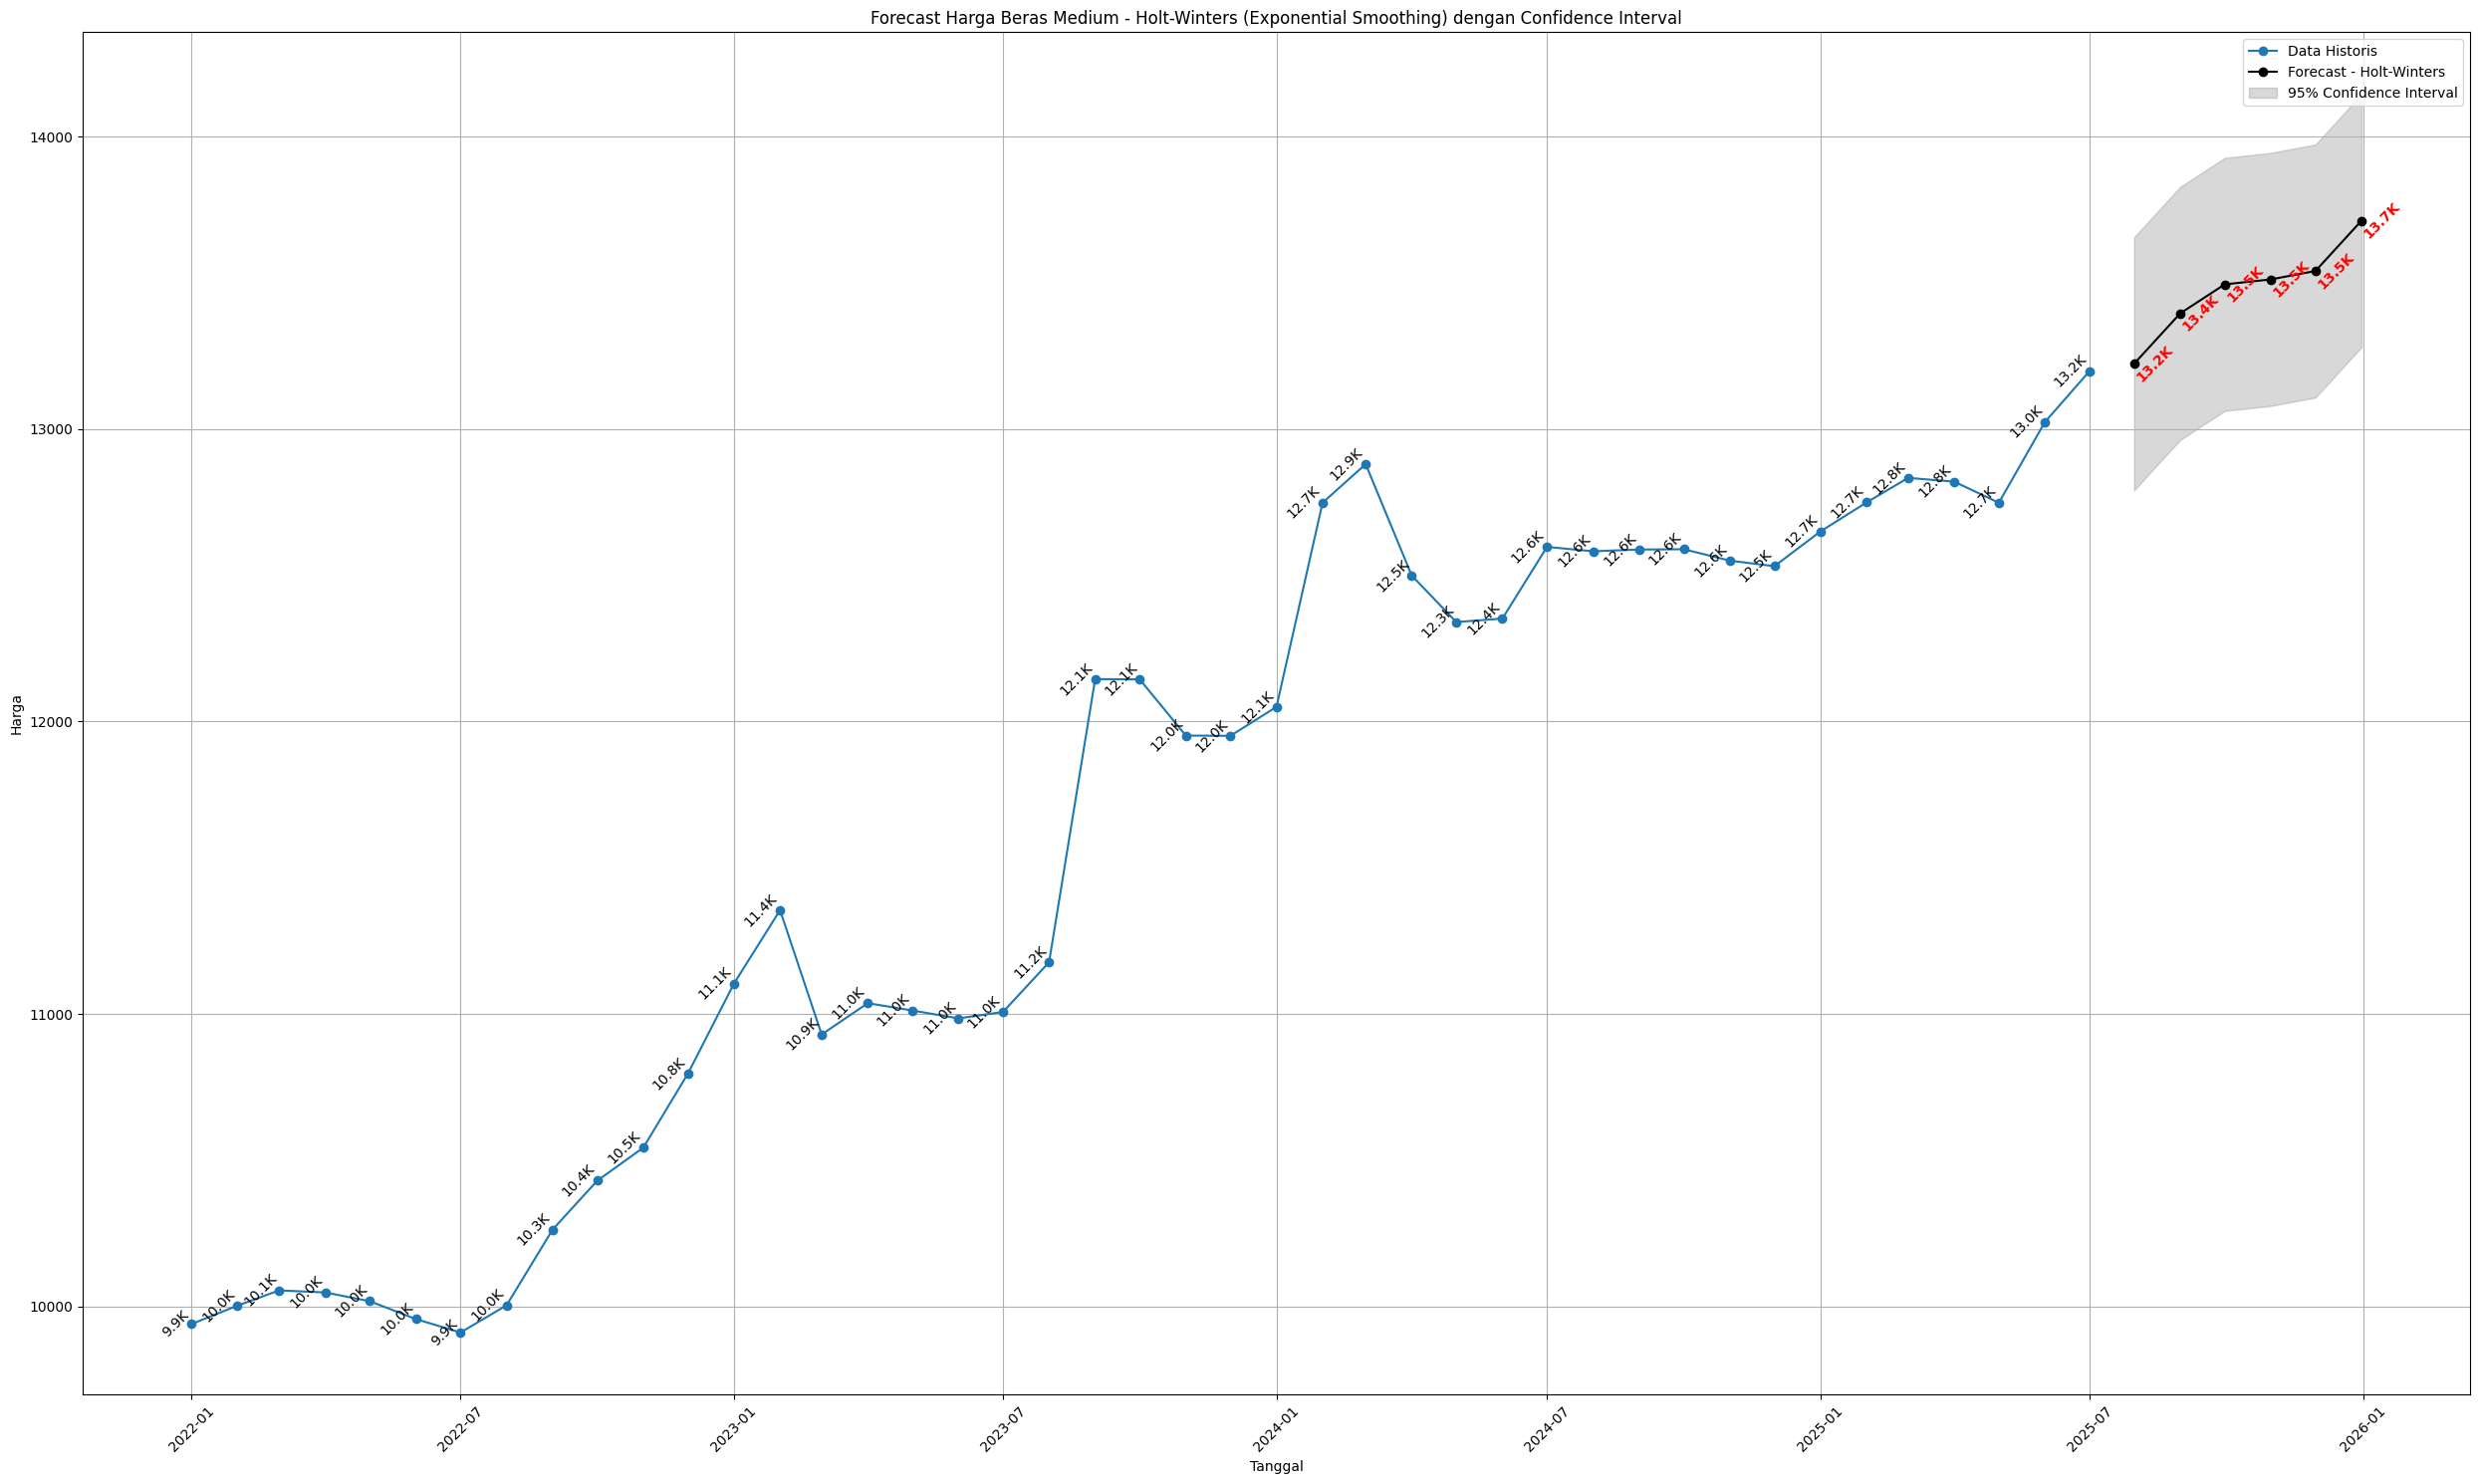

In [58]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Model Holt-Winters
model = ExponentialSmoothing(df_beras['Harga'], trend='add', seasonal='add', seasonal_periods=4).fit()
forecast_expo = model.forecast(steps=6)

# Hitung residual dan standar deviasi dari model
residuals = model.resid
std = np.std(residuals)

# Confidence interval (95%)
lower_bound = forecast_expo - 1.96 * std
upper_bound = forecast_expo + 1.96 * std

# Tanggal prediksi
future_dates = pd.date_range(start=df_beras.index[-1] + pd.offsets.MonthEnd(), periods=6, freq='M')

# Plot
plt.figure(figsize=(25, 15))
plt.plot(df_beras.index, df_beras['Harga'], label='Data Historis', marker='o')
plt.plot(future_dates, forecast_expo, label='Forecast - Holt-Winters', color='black', marker='o')

# Tambahkan Confidence Bands
plt.fill_between(future_dates, lower_bound, upper_bound, color='gray', alpha=0.3, label='95% Confidence Interval')

# Menampilkan angka dari data historis
for i, value in enumerate(df_beras['Harga']):
    plt.text(df_beras.index[i], value + 0.5, f"{value/1000:.1f}K", ha="right", va='center', fontsize=10, rotation=45)

# Menampilkan angka dari hasil forecast
for i, value in enumerate(forecast_expo):
    plt.text(future_dates[i], value + 0.5, f"{value/1000:.1f}K", ha='left', va='center', color='red', fontsize=10, rotation=45, weight='bold')

# Visual
plt.title("Forecast Harga Beras Medium - Holt-Winters (Exponential Smoothing) dengan Confidence Interval")
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Final Visualisasi

d:\MAGANG\Bulog\pycaret-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\MAGANG\Bulog\pycaret-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\MAGANG\Bulog\pycaret-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\MAGANG\Bulog\pycaret-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\MAGANG\Bulog\pycaret-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS w

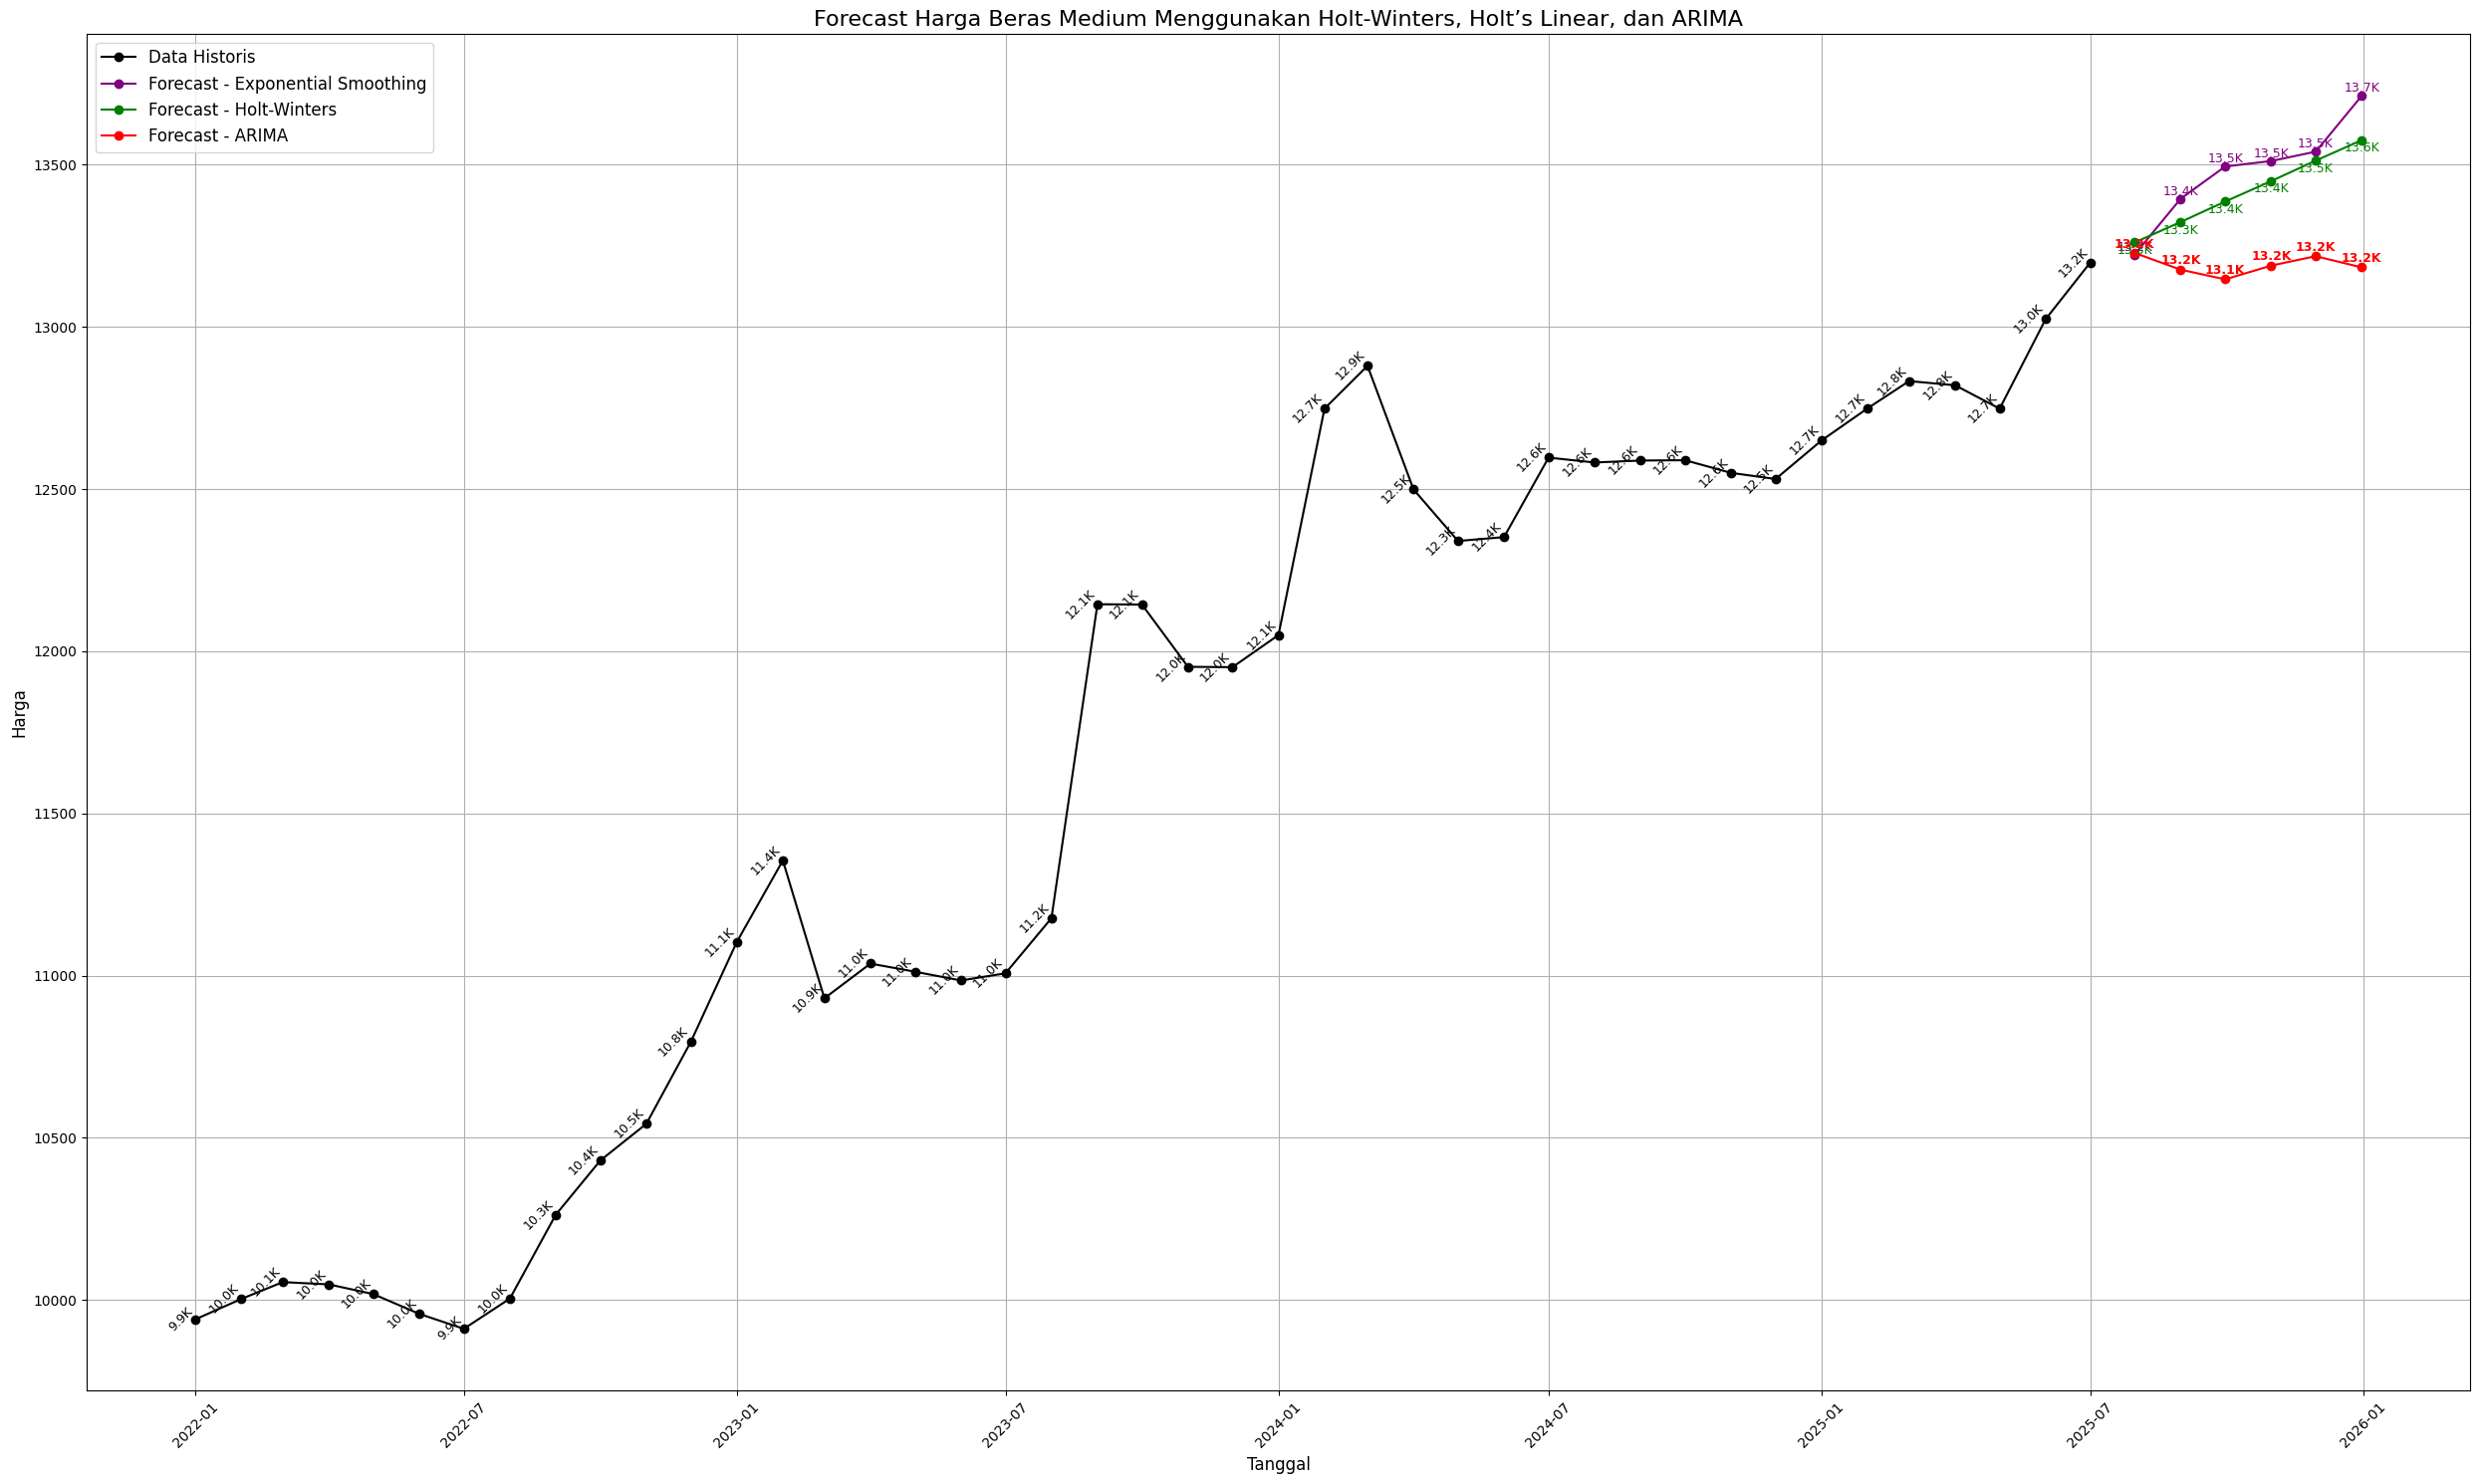

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA

# Asumsikan df_beras sudah ada dan disiapkan (sorted & indexed sebagai datetime)
# Model Holt-Winters
model_expo = ExponentialSmoothing(df_beras['Harga'], trend='add', seasonal='add', seasonal_periods=4).fit()
forecast_expo = model_expo.forecast(steps=6)

# Model Holt
model_holt = Holt(df_beras['Harga']).fit()
forecast_holt = model_holt.forecast(steps=6)

# Model ARIMA
model_arima = ARIMA(df_beras['Harga'], order=(2, 1, 2)).fit()
forecast_arima = model_arima.forecast(steps=6)

# Tanggal prediksi
future_dates = pd.date_range(start=df_beras.index[-1] + pd.offsets.MonthEnd(), periods=6, freq='M')

# Plot gabungan
plt.figure(figsize=(25, 15))
plt.plot(df_beras.index, df_beras['Harga'], label='Data Historis', color='black', marker='o')

# Forecast masing-masing model
plt.plot(future_dates, forecast_expo, label='Forecast - Exponential Smoothing', color='purple', marker='o')
plt.plot(future_dates, forecast_holt, label='Forecast - Holt-Winters', color='green', marker='o')
plt.plot(future_dates, forecast_arima, label='Forecast - ARIMA', color='red', marker='o')

# Menampilkan angka dari data historis
for i, value in enumerate(df_beras['Harga']):
    plt.text(df_beras.index[i], value + 0.5, f"{value/1000:.1f}K", ha="right", va='center', fontsize=9, rotation=45)

# Menampilkan angka forecast Holt-Winters
for i, value in enumerate(forecast_expo):
    plt.text(future_dates[i], value + 3, f"{value/1000:.1f}K", ha='center', va='bottom', fontsize=9, color='purple')

# Menampilkan angka forecast Holt
for i, value in enumerate(forecast_holt):
    plt.text(future_dates[i], value - 5, f"{value/1000:.1f}K", ha='center', va='top', fontsize=9, color='green')

# Menampilkan angka forecast ARIMA
for i, value in enumerate(forecast_arima):
    plt.text(future_dates[i], value + 7, f"{value/1000:.1f}K", ha='center', va='bottom', fontsize=9, color='red', weight='bold')

# Finalisasi
plt.title("Forecast Harga Beras Medium Menggunakan Exponential Smoothin, Holt-Winters, dan ARIMA", fontsize=16)
plt.xlabel("Tanggal", fontsize=12)
plt.ylabel("Harga", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
